In [518]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

# In the case of tomography retrieval (2D/ 3D)
Funcion 'los_points_fix_dl' is used to locate some points along the los with fixed distance. Function 'jacobian_row' is to compute pathlength corresponds to each measurement 

In [519]:
from geometry_functions import los_points_fix_dl
from oem_functions import jacobian_row

##### first we borrow some pointing vectors from ir database

In [520]:
from geometry_functions import lla2ecef
import pandas as pd
from osirisl1services.readlevel1 import open_level1_ir
from osirisl1services.services import Level1Services

channel = 3
orbit = 22015

ir = open_level1_ir(orbit, channel, valid=False)
tan_alt = ir.l1.altitude.sel(pixel=slice(14, 128,1))
tan_lat = ir.l1.latitude.sel(pixel=slice(14, 128, 1))
tan_lon = ir.l1.longitude.sel(pixel=slice(14, 128, 1))
sc_pos = ir.l1.position_ecef
#l1 = ir.data.sel(pixel=slice(14, 128)) #/np.pi
mjd = ir.mjd.data
pixel = tan_alt.pixel.data

tan_x, tan_y, tan_z = lla2ecef(tan_lat, tan_lon, tan_alt)
tan_xyz = xr.concat([tan_x, tan_y, tan_z],
                    pd.Index(['x', 'y', 'z'], name='xyz'))

sc_look = (tan_xyz - sc_pos)/np.linalg.norm(tan_xyz-sc_pos, axis=0)

im_lst = np.arange(800,900)

In [521]:
#change tan points coordinate
n_zenith = sc_pos.isel(mjd=0)
n_crosstrack = np.cross(sc_look.isel(mjd=0, pixel=0), n_zenith)
n_vel = np.cross(n_zenith, n_crosstrack)
n_z = n_zenith/np.linalg.norm(n_zenith)
n_x = n_crosstrack/np.linalg.norm(n_crosstrack)
n_y = n_vel/np.linalg.norm(n_vel)

#====tangent points in alpha, beta, rho coordinate
from geometry_functions import cart2sphe, change_of_basis
from geometry_functions import ecef2lla
tan_alpha = []
tan_beta = []
tan_rho = []

for i in mjd[im_lst]:
    p_old = tan_xyz.sel(mjd=i)
#    p_new = change_of_basis(n_crosstrack, n_vel, n_zenith, p_old)
    p_new = change_of_basis(n_x, n_y, n_z, p_old)
    alpha, beta, rho = cart2sphe(p_new.sel(xyz='x'),
                                 p_new.sel(xyz='y'),
                                 p_new.sel(xyz='z')) 
    tan_alpha.append(alpha)
    tan_beta.append(beta)
    tan_rho.append(rho)
tan_alpha = xr.DataArray(tan_alpha, 
                         coords=[mjd[im_lst], pixel],
                         dims=['mjd', 'pixel'])
tan_beta = xr.DataArray(tan_beta, 
                        coords=[mjd[im_lst], pixel],
                        dims=['mjd', 'pixel'])
tan_rho = xr.DataArray(tan_rho, 
                       coords=[mjd[im_lst], pixel],
                       dims=['mjd', 'pixel'])

#### define the atmospheric grid in alpha beta rho space

In [522]:
z = np.arange(60e3, 110e3, 1e3) # atmospheric grid
z_top = z[-1] + 2e3

#====define atmosphere grid (the bin edges)
edges_alpha = np.linspace(tan_alpha.min()-0.01,
                          tan_alpha.max()+0.01, 2) #radian
edges_beta = np.arange(tan_beta.min()-0.1,
                         tan_beta.max()+0.15, 0.02) #radian (resolution 0.2 degree in Degenstein 2004)
edges_rho = np.append(z,z_top) # meter
edges = edges_alpha, edges_beta, edges_rho

#====grid points for plotting
grid_alpha = np.append(edges_alpha - np.gradient(edges_alpha)/2, 
                       edges_alpha[-1]+np.gradient(edges_alpha)[-1]/2)
grid_beta = np.append(edges_beta - np.gradient(edges_beta)/2, 
                       edges_beta[-1]+np.gradient(edges_beta)[-1]/2)
grid_rho = np.append(edges_rho - np.gradient(edges_rho)/2, 
                       edges_rho[-1]+np.gradient(edges_rho)[-1]/2)

shape_tomo = (len(grid_alpha), len(grid_beta), len(grid_rho))


##### Pathlength calculation

In [523]:
#%% cal Jacobian

dl = 3e3 #fixed distance between all points
nop = 500 # choose number of points along the line
K_row_idx = []
K_col_idx = []
K_value = []
dll = dl * np.ones(nop) #temp
all_los_alpha, all_los_beta, all_los_rho = [], [], []
measurement_id = 0
for image in im_lst:
    #====generate points of los for all pixels in each image
    #====all points in cartesian coordinate relative to the space craft
    sc_look_new = change_of_basis(n_crosstrack, n_vel, n_zenith, 
                                  sc_look.isel(mjd=image))
    sc_pos_new = change_of_basis(n_crosstrack, n_vel, n_zenith, 
                                 sc_pos.isel(mjd=image))
    lx, ly, lz = los_points_fix_dl(sc_look_new, sc_pos_new, dl=dl, nop=nop)    
    #====convert xyz to alpha, beta, rho for all points
    los_alpha, los_beta, los_rho = cart2sphe(lx, ly, lz)
    all_los_alpha.append(los_alpha)
    all_los_beta.append(los_beta)
    all_los_rho.append(los_rho)
    
    #====build K
    for pix in pixel:#l1.pixel[l1.notnull().isel(mjd=image)]: 
        los = los_alpha.sel(pixel=pix), los_beta.sel(pixel=pix), los_rho.sel(pixel=pix)
        measurement_idx, grid_idx, pathlength = jacobian_row(dll, edges, los, measurement_id)
        K_row_idx.append(measurement_idx)
        K_col_idx.append(grid_idx)
        K_value.append(pathlength)
        measurement_id += 1
        
K_row_idx = np.concatenate(K_row_idx).astype('int')
K_col_idx = np.concatenate(K_col_idx).astype('int')
K_value = np.concatenate(K_value) *100 # in meter--> cm

#==== create sparse matrix
#====num of columns & rows of jacobian
col_len = len(grid_alpha) * len(grid_beta) * len(grid_rho)
row_len = len(pixel)*len(im_lst)#l1.isel(mjd=im_lst).notnull().sum().item()

from scipy.sparse import coo_matrix
K_coo = coo_matrix((K_value, (K_row_idx, K_col_idx)), shape = (row_len, col_len))


## Virtual measurement from virtual atmosphere

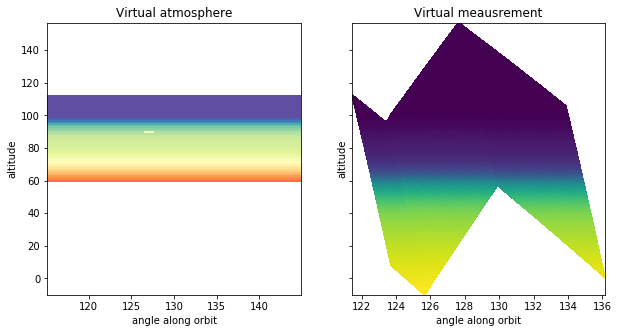

In [524]:
o2delta_load = np.load('../o2delta_profile.npz')['o2delta']
z_load = np.load('../o2delta_profile.npz')['z']
xa_1d = interp1d(z_load, o2delta_load, fill_value="extrapolate")(grid_rho)

v = np.tile(xa_1d, (len(grid_alpha),len(grid_beta),1))
#v = np.zeros(shape_tomo) #virtual atmosphere / VER
px = 2 #perturbation in ratio 
# index of vertical profile where the perturbation is
p_alpha = 1
p_beta = 10
p_rho = abs(grid_rho-90e3).argmin() 

v[p_alpha, p_beta, p_rho] = v[p_alpha, p_beta, p_rho] * px
y = K_coo.dot(v.ravel())


# plotting the virtual measurement and virtual atmosphere
fig, ax = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(10,5))
ax[0].pcolormesh(grid_beta*180/np.pi, grid_rho*1e-3, v[1,:,:].T,
                norm=LogNorm(vmin=1e5, vmax=1e7), cmap='Spectral_r')

ax[0].set(xlabel='angle along orbit',
          ylabel='altitude',
          title='Virtual atmosphere')
#ax[1].plot(y.reshape((len(im_lst), len(pixel))).T, 
#           tan_alt.isel(mjd=im_lst).T, '*')

ax[1].pcolormesh(tan_beta*180/np.pi, tan_rho*1e-3,
               y.reshape((len(im_lst), len(pixel))))
               
ax[1].set(xlabel='angle along orbit',
         ylabel='altitude',
         title='Virtual meausrement')

plt.show()

### Inverseion

In [525]:
from oem_functions import linear_oem_sp
import scipy.sparse as sp
from scipy.interpolate import interp1d

xa = np.tile(xa_1d, (len(grid_alpha),len(grid_beta),1)).ravel()
Sa = sp.diags((xa*1)**2, shape=(col_len, col_len))  #temp
Se = sp.diags([1], shape=(measurement_id, measurement_id))* (1e13)**2 #temp
x_hat, G = linear_oem_sp(K_coo, Se, Sa, y, xa)

result_tomo = x_hat.reshape(shape_tomo)
result_tomo = xr.DataArray(result_tomo, 
                           coords=(grid_alpha, grid_beta, grid_rho), 
                           dims=('alpha', 'beta', 'rho')) #temp

A = G.dot(K_coo)
mr_tomo = np.zeros(shape_tomo)
for alpha_id in range(len(grid_alpha)):
    for beta_id in range(len(grid_beta)):
        for rho_id in range(len(grid_rho)):
            grid_id = np.ravel_multi_index((alpha_id, beta_id, rho_id), shape_tomo)
            mr_tomo[alpha_id, beta_id, rho_id] = A[grid_id,:].toarray().squeeze().reshape(shape_tomo).sum()
mr_tomo = xr.DataArray(mr_tomo, coords=result_tomo.coords, dims=result_tomo.dims)



/home/anqil/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/anqil/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


#### plotting the inversion result

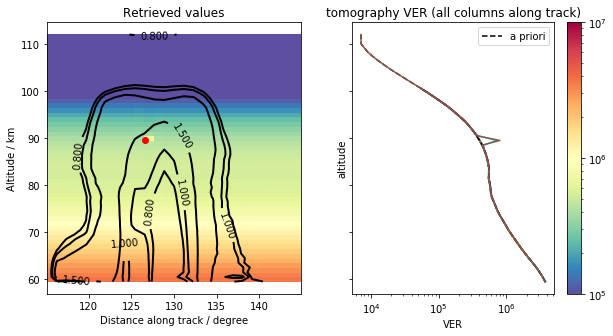

In [526]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(10,5))
result_tomo_masked = np.ma.masked_where(mr_tomo.isel(alpha=1)<0.8, 
                                        result_tomo.isel(alpha=1))
main = ax[0].pcolormesh(grid_beta*180/np.pi, grid_rho*1e-3, 
#                 result_tomo_masked.T,
                 result_tomo.isel(alpha=1).T, 
                 norm=LogNorm(vmin=1e5, vmax=1e7), cmap='Spectral_r')
ax[0].plot(grid_beta[p_beta]*180/np.pi, grid_rho[p_rho]*1e-3, 'ro')
ax[0].set(xlabel='Distance along track / degree',
         ylabel='Altitude / km',
         title='Retrieved values')

plt.colorbar(main)
#plt.scatter(tan_beta.where(tan_rho>bot).where(tan_rho<top)*Re, 
#            tan_rho.where(tan_rho>bot).where(tan_rho<top)*1e-3, s=.2, c='k')
CS = ax[0].contour(grid_beta*180/np.pi, grid_rho*1e-3, mr_tomo.isel(alpha=1).T,
           levels=[0.8, 1, 1.5], colors=('k',), linestyles=('-',),linewidths=(2,))
ax[0].clabel(CS, inline=1, fontsize=10)

#==== vertical profiles within the 3D matrix

ax[1].set_xscale('linear')
ax[1].set(xlabel='VER',
      ylabel='altitude',
      title='tomography VER (all columns along track)')
for i in range(1,len(grid_alpha)-1):
    for j in range(1, len(grid_beta)-1):
#        ax[1].semilogx(result_tomo.where(mr_tomo>0.9)[i,j,:], grid_rho*1e-3, '-')
        ax[1].semilogx(result_tomo_masked[j,:], grid_rho*1e-3, '-')
ax[1].semilogx(xa_1d, grid_rho*1e-3, 'k--', label='a priori')
ax[1].semilogx(v[p_alpha, p_beta, :], grid_rho*1e-3)
plt.legend()
plt.show()

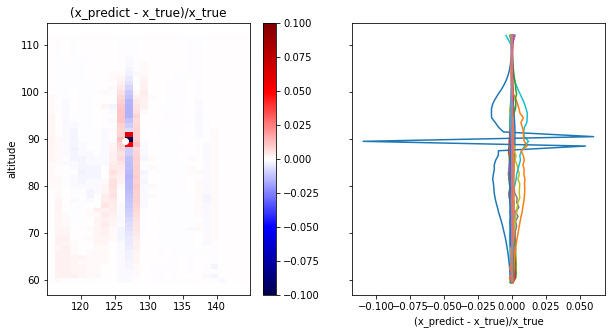

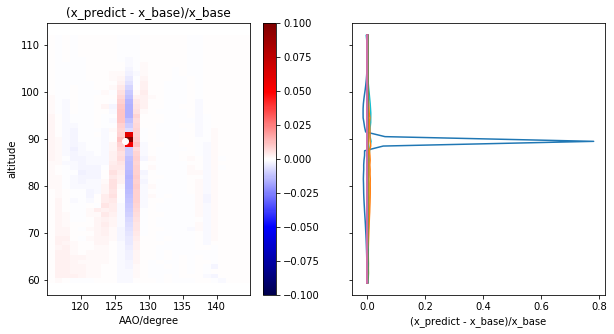

403157.3604239989 dx = x_true - x_base
314577.7735484324 (x_hat - x_base) at position perturbed
-88579.58687556651 (x_hat - x_true) at position perturbed


In [527]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(10,5))
C = ax[0].pcolormesh(grid_beta*180/np.pi, grid_rho*1e-3,
                    ((x_hat.reshape(shape_tomo)-v)/v)[1,:,:].T,
                    cmap='seismic', 
                    vmin=-0.1, 
                    vmax=0.1)
ax[0].plot(grid_beta[p_beta]*180/np.pi, grid_rho[p_rho]*1e-3, 'wo')
ax[0].set(title = '(x_predict - x_true)/x_true',
          ylabel='altitude')
plt.colorbar(C, ax=ax[0])
ax[1].plot(((x_hat.reshape(shape_tomo)-v)/v)[1,:,:].T, grid_rho*1e-3)
ax[1].set(xlabel= '(x_predict - x_true)/x_true')
plt.show()

fig, ax = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(10,5))
C = ax[0].pcolormesh(grid_beta*180/np.pi, grid_rho*1e-3, 
              ((x_hat - xa)/xa).reshape(shape_tomo)[1,:,:].T,
              cmap='seismic', 
              vmin=-0.1, 
              vmax=0.1)
ax[0].plot(grid_beta[p_beta]*180/np.pi, grid_rho[p_rho]*1e-3, 'wo')
ax[0].set(xlabel='AAO/degree',
          ylabel='altitude',
         title='(x_predict - x_base)/x_base')
plt.colorbar(C, ax=ax[0])

ax[1].plot(((x_hat - xa)/xa).reshape(shape_tomo)[1,:,:].T, grid_rho*1e-3)
ax[1].set(xlabel='(x_predict - x_base)/x_base')
plt.show()

print(v[1, p_beta, p_rho] - xa.reshape(shape_tomo)[1, p_beta, p_rho],
     'dx = x_true - x_base')
print((x_hat-xa).reshape(shape_tomo)[p_alpha,p_beta, p_rho], 
      '(x_hat - x_base) at position perturbed')
print((x_hat.reshape(shape_tomo)-v)[p_alpha,p_beta, p_rho], 
      '(x_hat - x_true) at position perturbed')



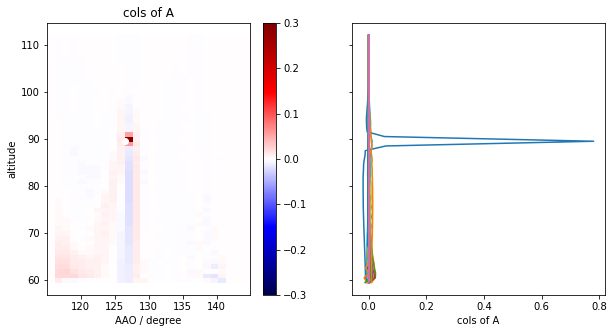

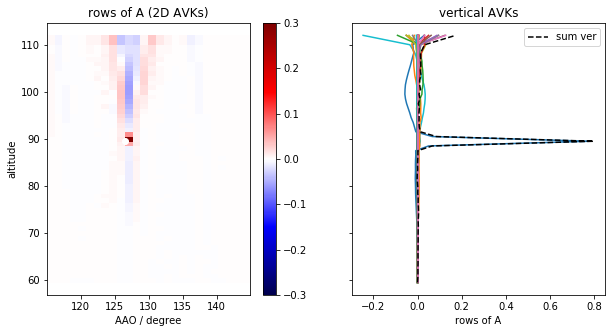

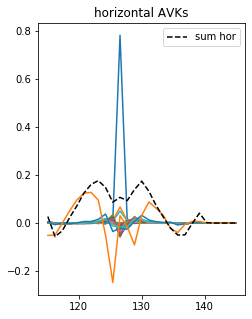

In [528]:
grid_id = np.ravel_multi_index((1, p_beta, p_rho), shape_tomo)
AC = A[:,grid_id].toarray().squeeze().reshape(shape_tomo)
AR = A[grid_id,:].toarray().squeeze().reshape(shape_tomo)

fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(10,5))
C = ax[0].pcolormesh(grid_beta*180/np.pi, grid_rho*1e-3, AC[1,:,:].T,
                    cmap='seismic', 
                     vmin=-0.3, 
                     vmax=0.3)
plt.colorbar(C, ax=ax[0])
ax[0].plot(grid_beta[p_beta]*180/np.pi, grid_rho[p_rho]*1e-3, 'wo')
ax[0].set(title='cols of A',
         xlabel='AAO / degree',
          ylabel='altitude')

ax[1].plot(AC[1,:,:].T, grid_rho*1e-3)
#ax[1].plot(AC[1,:,:].sum(axis=0), grid_rho*1e-3, 'k--')
ax[1].set(xlabel='cols of A')
plt.show()



fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(10,5))
C = ax[0].pcolormesh(grid_beta*180/np.pi, grid_rho*1e-3, AR[1,:,:].T,
                    cmap='seismic', 
                     vmin=-0.3, 
                     vmax=0.3)
plt.colorbar(C, ax=ax[0])
ax[0].plot(grid_beta[p_beta]*180/np.pi, grid_rho[p_rho]*1e-3, 'wo')
ax[0].set(title='rows of A (2D AVKs)',
         xlabel='AAO / degree',
          ylabel='altitude')
ax[1].plot(AR[1,:,:].T, grid_rho*1e-3)
ax[1].plot(AR[1,:,:].sum(axis=0), grid_rho*1e-3, 'k--', label='sum ver')

ax[1].set(xlabel='rows of A',
         title='vertical AVKs')
plt.legend()
plt.show()

plt.figure(figsize=(3.7,5))
plt.plot(grid_beta*180/np.pi, AR[1,:,:])
plt.plot(grid_beta*180/np.pi, AR[1,:,:].sum(axis=1), 'k--', label='sum hor')
plt.title('horizontal AVKs')
plt.legend()
plt.show()

# In case of 1D inversion

In [529]:
from geometry_functions import pathl1d_iris

h = tan_alt.isel(mjd=im_lst[50]) # measurement altitude
K = pathl1d_iris(h, z, z_top) 
v_1d = interp1d(z_load, o2delta_load, fill_value="extrapolate")(z) 
p_z = abs(z-90e3).argmin() # where to perturb
v_1d[p_z] = v_1d[p_z] * px # add perturbation
y = K.dot(v_1d) # vitual measurement


### inversion

In [530]:
from oem_functions import linear_oem
xa_1d = interp1d(z_load, o2delta_load, fill_value="extrapolate")(z) 
Se = np.diag(np.ones(len(y)))* (1e11)**2
Sa = np.diag(xa_1d**2)
x_hat_1d, A_1d, Ss, Sm = linear_oem(K, Se, Sa, y, xa_1d)

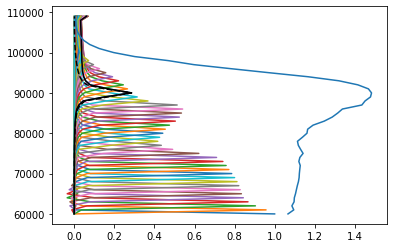

In [533]:
for i in range(len(z)):
    plt.plot(A_1d[i,:], z)
plt.plot(A_1d[p_z, :], z, 'k-')
plt.plot(A_1d.sum(axis=1), z)


plt.plot((x_hat_1d - xa_1d)/xa_1d, z, 'k--')
plt.show()

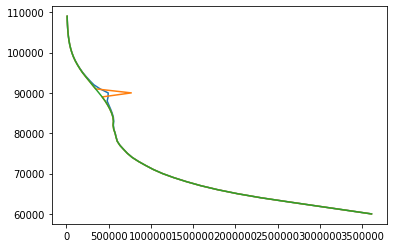

In [532]:
plt.plot(x_hat_1d,z)
plt.plot(v_1d, z)
plt.plot(xa_1d,z)